In [1]:
#拡張機能のインポート
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

N=50                 #データ数
D = 3                 #データの次元数(観測空間の次元)
nodes = 10              #潜在空間の一次元あたりのノード数？
L = 2                #潜在空間の次元数
K = nodes**L #潜在空間のノード数
T = 100         #総学習回数 ここは変えて良いのかな?
seed = 10
sigma_max = 3.0
sigma_min = 0.1

Xのシェイプ (50, 3)


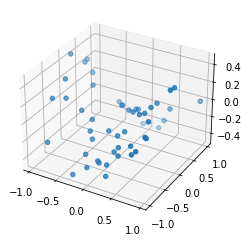

In [2]:
#観測データ
def gen_kura_data(num):
    #num = params.num_samples
    np.random.seed(0)
    z1 = np.random.uniform(low=-1, high=+1, size=(num))
    z2 = np.random.uniform(low=-1, high=+1, size=(num))

    X = np.empty(shape=(num, 3))
    X[:, 0] = z1
    X[:, 1] = z2
    X[:, 2] = 0.5 * (z1**2 - z2**2)
    return X

X = gen_kura_data(N)
print("Xのシェイプ",X.shape)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d') #三次元マップの描画
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
plt.show()

M (100, 2)


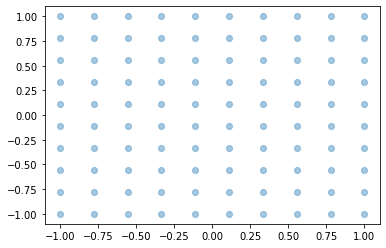

In [3]:
#ノードが存在する範囲？の設定 テクニックドリルを参照（詳しくは）
#潜在空間を離散化する(潜在変数にK個の座標を配置する). 
A = np.linspace(-1,1,nodes)
B = np.linspace(-1,1,nodes)
XX, YY = np.meshgrid(A,B)
xx = XX.reshape(-1)
yy = YY.reshape(-1)
M = np.concatenate([xx[:, None], yy[:, None]], axis=1) #変数表でいうζkに該当する

print("M",M.shape)
plt.scatter(M[:, 0], M[:, 1], alpha=0.4)

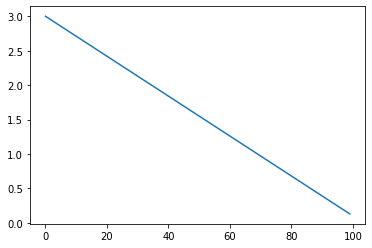

In [4]:
 #近傍半径を減少させるスケージュリーングの設定、ς関数の描画
def estimate_sigma(T, t, sigma_max, sigma_min):
    #パワーポイントの式を参照
    sigma = ((sigma_min - sigma_max) / T) * t  +  sigma_max
    return sigma


#sigmaの図の描写
sigma_box = []
time_box = []
for t in range(T):
    sigma = estimate_sigma(T, t, sigma_max, sigma_min)
    sigma_box.append(sigma)
    time_box.append(t)
plt.plot(time_box, sigma_box)

In [5]:
#潜在変数を乱数で初期化
Z = np.random.rand(N,L)

#データの距離
def distance_function(A,B):
    distance= np.sum((A[:, None, :]-B[None, :, :])**2, axis=2)
    return distance
Distance = distance_function(M,Z)
Distance.shape

(100, 50)

In [6]:
def Reference_vector(t, T, Z, M, X, sigam):
    #R_knの式
    R_kn = np.exp((-1/(2*sigma**2))*distance_function(M,Z))
    #print(R_kn.shape)
    #g_kの式 K次元のベクトル このオプションで潰れるのを防ぐ
    g_k = np.sum(R_kn, axis=1,keepdims=True)
    #print(g_k.shape)
    #y_kの式 エラー出る、ヒント：行列積、シェイプを意識しよう
    H = R_kn/g_k
    Y = H @ X
    #print(Y.shape)
    #y_k = (1/g_k)*np.sum()
    #print(sigma)
    return Y

In [7]:
def estimate_Z(X, Y):
    Distance = np.sum((X[None, :, :] - Y[:, None, :])**2,axis=2)
    k_star = np.argmin(Distance, axis=0)
    Z = M[k_star, :]
    return Z

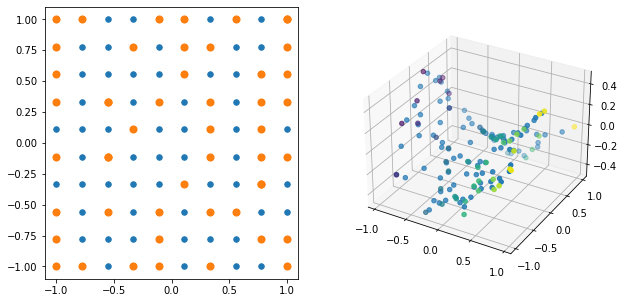

In [8]:
for t in range(T):
    sigma = estimate_sigma(T, t, sigma_max, sigma_min)
    Y = Reference_vector(t, T, Z, M, X, sigma)
    Z = estimate_Z(X, Y)
    
    
# 下コードは上手くいっているかの確認コード, Yの点が全体を覆い尽くしていればok
fig = plt.figure(figsize=(10, 5))
ax_observable = fig.add_subplot(122, projection="3d")
ax_latent = fig.add_subplot(121)

ax_latent.scatter(M[:, 0], M[:, 1], s=30)
ax_latent.scatter(Z[:, 0], Z[:, 1], s=50)
ax_observable.scatter(X[:, 0], X[:, 1],X[:, 2], c=X[:, 0])
ax_observable.scatter(Y[:, 0], Y[:, 1],Y[:, 2])
plt.show()

In [9]:
#以下図をanimationで見るためのコードを書く

#シェイプのTの部分でanimationを行う
history_Z =np.zeros((T, N, L))
history_y =np.zeros((T, K, D))

for t in range(T):
    sigma = estimate_sigma(T, t, sigma_max, sigma_min)
    Y = Reference_vector(t, T, Z, M, X, sigma)
    Z = estimate_Z(X, Y)
    history_y[t] = Y
    history_Z[t] = Z
f = history_y.reshape(T, nodes, nodes, D)

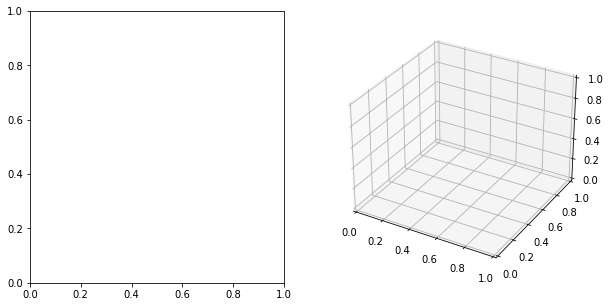

In [15]:
fig = plt.figure(figsize=(10, 5))
ax_observable = fig.add_subplot(122, projection='3d')
ax_latent = fig.add_subplot(121)

def update(i, M, z, f, x):
    plt.cla()
    ax_latent.cla()
    ax_observable.cla()

    fig.suptitle(f"epoch: {i}")
    
    ax_latent.scatter(M[:, 0], M[:, 1], s=30, alpha=0.5)
    ax_latent.scatter(z[i, :, 0], z[i, :, 1], s=50, edgecolors="k", c=x[:, 0])
    ax_observable.scatter(x[:, 0], x[:, 1],x[:, 2], c=x[:, 0], s=50, marker='x')
    ax_observable.plot_wireframe(f[i, :, :, 0], f[i, :, :, 1],f[i, :, :, 2], color='black')
    

    ax_observable.set_xlim(x[:, 0].min(), x[:, 0].max())
    ax_observable.set_ylim(x[:, 1].min(), x[:, 1].max())

    ani = animation.FuncAnimation(fig, update, fargs=(M, history_Z, f , X), interval=100, frames=100)
    
plt.show()